In [20]:
%pip install mne


Note: you may need to restart the kernel to use updated packages.


Load the Deap Dataset 

In [13]:
import os
import numpy as np
import pickle

# Corrected path for macOS
dataset_path = "/Users/kostasbekis/Emotion_detection/Deap_dataset/deap/data_preprocessed_python"

# List all .dat files in the directory
eeg_data_files = [f for f in os.listdir(dataset_path) if f.endswith('.dat')]

# Initialize lists for storing data and labels
all_data = []
all_labels = []

subjects = 32
trials = 40
electrodes = 32  # Now we are using only the first 32 channels
fs = 128  # Sampling frequency in DEAP dataset
total_length = 8064  # 63 sec
pretrial = fs * 3  # Pretrial baseline
data_length = total_length - pretrial  # Useful signal

# Check if the files are loaded correctly
print(f"EEG Data Files: {eeg_data_files}")

# Load EEG data and labels
all_data, all_labels = [], []
for file in eeg_data_files:
    with open(os.path.join(dataset_path, file), 'rb') as f:
        file_data = pickle.load(f, encoding='latin1')
        all_data.append(file_data['data'])  # EEG data
        all_labels.append(file_data['labels'])  # Emotion labels

# Convert lists to numpy arrays
eeg_data = np.array(all_data)
eeg_data = eeg_data[:, :, :32, :]  # Only take the first 32 channels
emotion_labels = np.array(all_labels)

# Check the shape of the EEG data and labels
print(f"EEG Data Shape: {eeg_data.shape}")
print(f"Emotion Labels Shape: {emotion_labels.shape}")

EEG Data Files: ['s28.dat', 's14.dat', 's01.dat', 's15.dat', 's29.dat', 's03.dat', 's17.dat', 's16.dat', 's02.dat', 's06.dat', 's12.dat', 's13.dat', 's07.dat', 's11.dat', 's05.dat', 's04.dat', 's10.dat', 's09.dat', 's21.dat', 's20.dat', 's08.dat', 's22.dat', 's23.dat', 's27.dat', 's32.dat', 's26.dat', 's30.dat', 's24.dat', 's18.dat', 's19.dat', 's25.dat', 's31.dat']
EEG Data Shape: (32, 40, 32, 8064)
Emotion Labels Shape: (32, 40, 4)


In [14]:
# Epoch data (Segmentation)
window = 6  # Window length in seconds
overlap = 6 * 0.5  # 50% overlap
number_of_segments = int((data_length - (overlap * fs)) / (overlap * fs))  # Number of segments
print(f"Number of segments per trial: {number_of_segments}")

eeg_data_segmented = np.zeros((subjects, trials, number_of_segments, electrodes, window * fs))

# Apply sliding window segmentation with overlap
count = 0
for epoch in range(number_of_segments):
    window_size = int(window * fs)
    eeg_data_segmented[:, :, epoch] = eeg_data[:, :, :, count:count + window_size]
    count += int(overlap * fs)

# Now eeg_data_segmented has shape (subjects, trials, segments, electrodes, window * fs)
print(f"Segmented EEG Data Shape: {eeg_data_segmented.shape}")

Number of segments per trial: 19
Segmented EEG Data Shape: (32, 40, 19, 32, 768)


EEG Data Shape (32, 40, 40, 8064):

32: The number of participants (or subjects) in the dataset.
40: The number of channels (electrodes) for each EEG recording.
40: This could represent the number of trials or time segments for each subject.
8064: The number of time samples per trial.
Emotion Labels Shape (32, 40, 4):

32: The number of participants.
40: The number of trials or time segments for each subject.
4: The emotion labels for each trial, representing the valence, arousal, dominance, and liking scores.

Segmented EEG Data Shape: (32, 40, 19, 32, 768)
Emotion Labels Shape: (32, 40, 4)
Segmented EEG Data for Subject 0, Trial 0, Segment 0 (shape (32, 768)):
[[ 41.61858905  33.1385982   -4.10934406 ...  28.3698295  -15.05396971
  -34.91768662]
 [ 32.60365733  16.36290704 -24.65479936 ...  27.53963067 -13.93042713
  -32.94324229]
 [ 45.35555741  50.36371001  37.57930277 ...  20.16552929  -7.60758381
  -22.56992988]
 ...
 [ 21.89366994   1.95615234 -17.51790193 ...  20.70366304 -14.41463322
  -26.53623864]
 [-49.60924288 -37.95888618   0.70971674 ... -32.42334391  11.97635627
   36.33054763]
 [  8.79451163  -9.89845495 -24.58035356 ...   9.81971887 -12.11380811
  -18.2108815 ]]


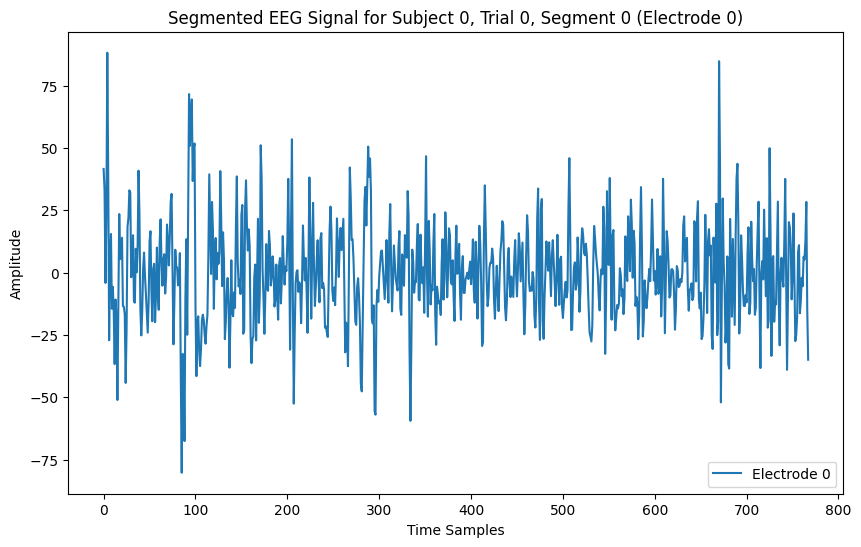

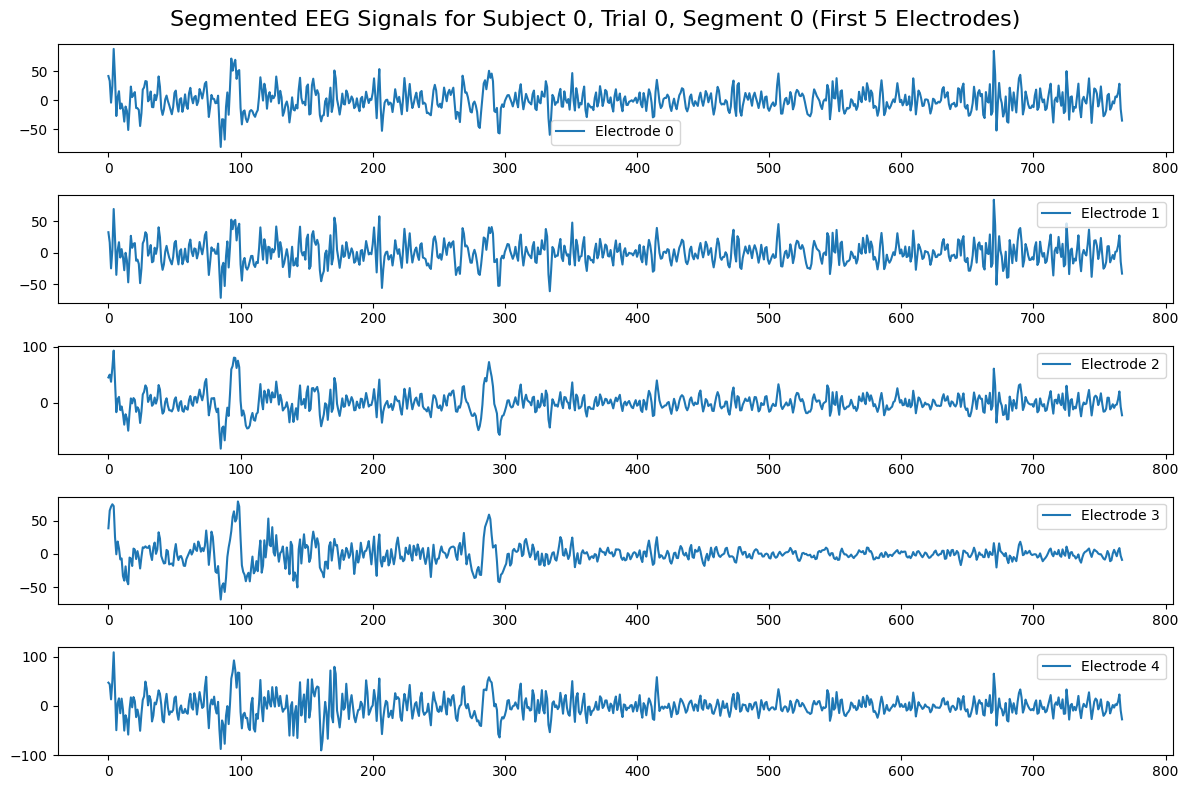

Number of NaN values in the segmented EEG data: 0
Number of infinite values in the segmented EEG data: 0
Mean of segmented EEG signals for Subject 0 (per electrode): [[ 3.00801051e-16 -1.47104551e-16 -3.35842465e-16 ... -4.51028104e-17
  -8.18789481e-17 -8.88178420e-17]
 [-1.40165657e-16  1.20042865e-16  5.38111222e-16 ...  3.74700271e-17
  -1.38777878e-18 -1.88044025e-16]
 [-9.92261828e-17  1.15185639e-16  1.11022302e-16 ... -4.71844785e-17
  -9.02056208e-18  3.46944695e-19]
 ...
 [-1.61329283e-17  2.91607016e-16 -7.21644966e-17 ...  9.15933995e-17
   5.20417043e-17  6.24500451e-17]
 [ 9.43689571e-17 -2.19008839e-16  1.29757316e-16 ... -2.72004641e-16
   2.19269047e-16 -1.83186799e-16]
 [ 1.72084569e-16 -2.56045185e-16  4.57966998e-17 ... -2.05044315e-16
   6.66133815e-17  9.43689571e-17]]
Standard deviation of segmented EEG signals for Subject 0 (per electrode): [[23.07715867 30.02268728 39.96921976 ... 23.86783904 21.66101755
  21.54830186]
 [18.45663552 25.18895447 24.93867088 ... 

In [15]:
import matplotlib.pyplot as plt

# Check the shape of the segmented EEG data and emotion labels
print(f"Segmented EEG Data Shape: {eeg_data_segmented.shape}")
print(f"Emotion Labels Shape: {emotion_labels.shape}")

# Inspecting the first few entries in the EEG data (subject 0, trial 0, segment 0)
subject_0_trial_0_segment_0 = eeg_data_segmented[0, 0, 0, :, :]
print(f"Segmented EEG Data for Subject 0, Trial 0, Segment 0 (shape {subject_0_trial_0_segment_0.shape}):")
print(subject_0_trial_0_segment_0)

# Plot a sample EEG signal from one electrode (e.g., electrode 0 for subject 0, trial 0, segment 0)
plt.figure(figsize=(10, 6))
plt.plot(subject_0_trial_0_segment_0[0, :], label='Electrode 0')
plt.title('Segmented EEG Signal for Subject 0, Trial 0, Segment 0 (Electrode 0)')
plt.xlabel('Time Samples')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

# Plot the first 5 electrodes of Subject 0, Trial 0, Segment 0 to compare different electrodes
plt.figure(figsize=(12, 8))
for i in range(5):  # Plot first 5 electrodes
    plt.subplot(5, 1, i + 1)
    plt.plot(subject_0_trial_0_segment_0[i, :], label=f'Electrode {i}')
    plt.legend()
plt.suptitle('Segmented EEG Signals for Subject 0, Trial 0, Segment 0 (First 5 Electrodes)', fontsize=16)
plt.tight_layout()
plt.show()

# Checking for NaN or infinite values in the segmented EEG data
nan_values_segmented = np.isnan(eeg_data_segmented).sum()
infinite_values_segmented = np.isinf(eeg_data_segmented).sum()
print(f"Number of NaN values in the segmented EEG data: {nan_values_segmented}")
print(f"Number of infinite values in the segmented EEG data: {infinite_values_segmented}")

# Basic statistics for the first subject (on segmented data)
subject_0_segmented_data = eeg_data_segmented[0, :, :, :]
mean_segmented_signal = np.mean(subject_0_segmented_data, axis=(0, 2))  # Mean across trials, segments, and time
std_segmented_signal = np.std(subject_0_segmented_data, axis=(0, 2))    # Std dev across trials, segments, and time

print(f"Mean of segmented EEG signals for Subject 0 (per electrode): {mean_segmented_signal}")
print(f"Standard deviation of segmented EEG signals for Subject 0 (per electrode): {std_segmented_signal}")


Checking Distributions

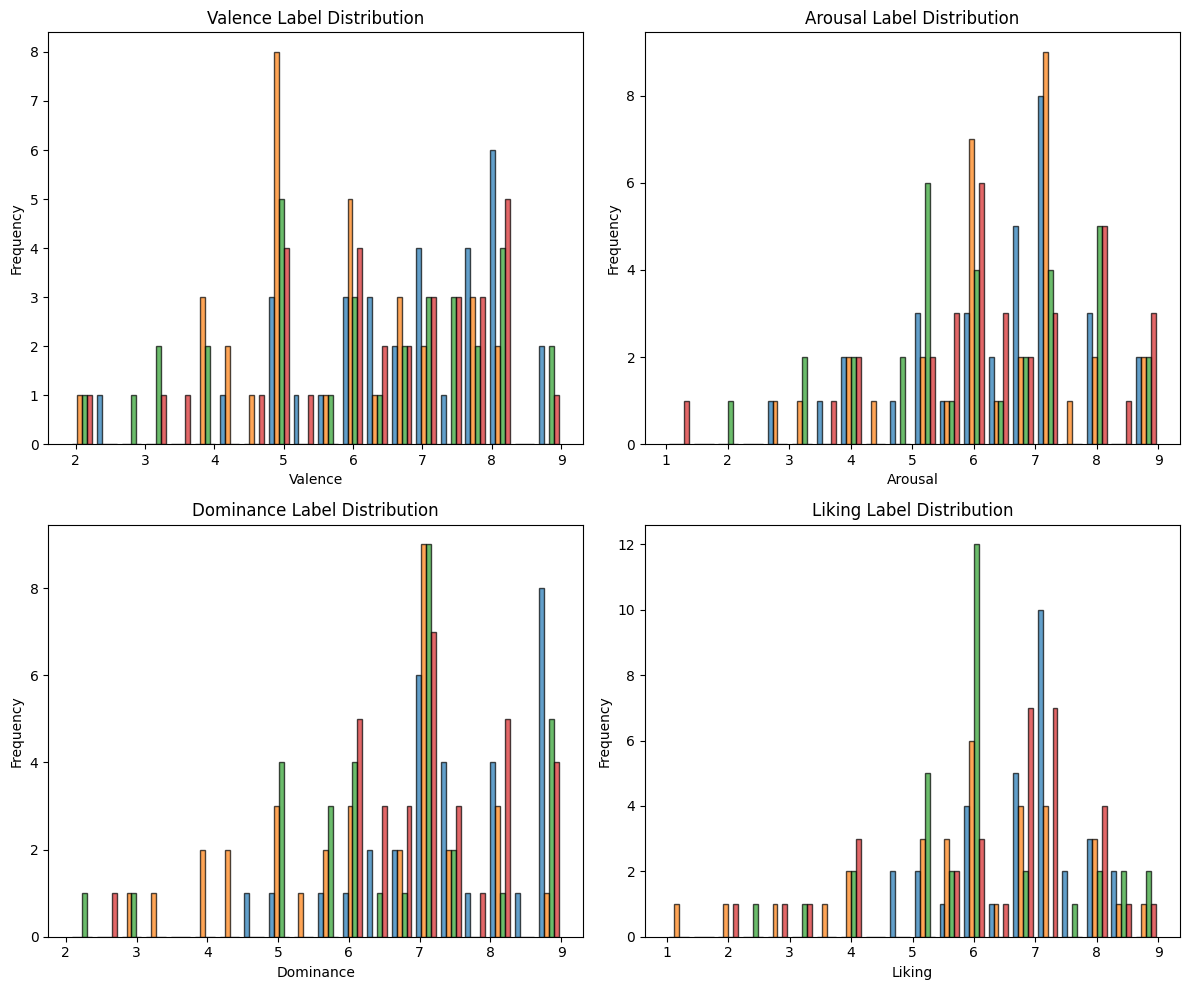

Valence Class Distribution: {1.92: 1, 1.97: 1, 1.99: 1, 2.51: 1, 2.9: 1, 2.99: 2, 3.01: 1, 3.55: 1, 3.78: 1, 4.0: 1, 4.01: 1, 4.03: 1, 4.04: 1, 4.05: 1, 4.13: 1, 4.21: 1, 4.45: 1, 4.67: 1, 4.78: 1, 4.83: 1, 4.87: 1, 4.9: 1, 4.97: 2, 5.01: 2, 5.03: 2, 5.04: 7, 5.05: 2, 5.06: 1, 5.31: 1, 5.33: 1, 5.65: 1, 5.74: 1, 5.76: 1, 5.86: 1, 5.91: 1, 5.92: 1, 5.96: 1, 5.97: 1, 6.0: 1, 6.03: 1, 6.04: 1, 6.05: 1, 6.06: 1, 6.08: 1, 6.09: 1, 6.13: 1, 6.15: 2, 6.21: 1, 6.26: 1, 6.27: 1, 6.33: 1, 6.42: 1, 6.45: 1, 6.5: 1, 6.56: 2, 6.62: 1, 6.67: 1, 6.68: 1, 6.74: 1, 6.78: 1, 6.79: 1, 6.82: 1, 6.9: 1, 6.95: 1, 6.97: 1, 7.03: 1, 7.04: 1, 7.06: 2, 7.09: 2, 7.1: 1, 7.12: 1, 7.13: 1, 7.24: 1, 7.26: 1, 7.41: 1, 7.42: 1, 7.44: 1, 7.47: 2, 7.6: 2, 7.63: 1, 7.71: 3, 7.74: 1, 7.78: 1, 7.83: 1, 7.86: 1, 7.9: 1, 7.91: 1, 7.97: 1, 8.01: 2, 8.03: 1, 8.04: 1, 8.06: 1, 8.08: 2, 8.09: 2, 8.1: 2, 8.13: 1, 8.14: 1, 8.19: 1, 8.22: 2, 8.86: 1, 8.9: 1, 9.0: 3}
Arousal Class Distribution: {1.01: 1, 1.99: 1, 2.99: 2, 3.08: 1, 

In [16]:
# Load the emotion labels if not already loaded (assuming the variable emotion_labels is available)
# For demonstration, I'll redefine the 'emotion_labels' variable and proceed with the class distribution analysis.

# Load the emotion labels (replace with the actual variable if available)
emotion_labels = np.array(all_labels)  # This is assuming all_labels is already defined as before

# Extracting the labels for all 4 emotions (valence, arousal, dominance, liking)
valence_labels = emotion_labels[:, 0]
arousal_labels = emotion_labels[:, 1]
dominance_labels = emotion_labels[:, 2]
liking_labels = emotion_labels[:, 3]

# Plot the distribution of each emotion label
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot for Valence
axes[0, 0].hist(valence_labels, bins=20, edgecolor='black', alpha=0.7)
axes[0, 0].set_title("Valence Label Distribution")
axes[0, 0].set_xlabel("Valence")
axes[0, 0].set_ylabel("Frequency")

# Plot for Arousal
axes[0, 1].hist(arousal_labels, bins=20, edgecolor='black', alpha=0.7)
axes[0, 1].set_title("Arousal Label Distribution")
axes[0, 1].set_xlabel("Arousal")
axes[0, 1].set_ylabel("Frequency")

# Plot for Dominance
axes[1, 0].hist(dominance_labels, bins=20, edgecolor='black', alpha=0.7)
axes[1, 0].set_title("Dominance Label Distribution")
axes[1, 0].set_xlabel("Dominance")
axes[1, 0].set_ylabel("Frequency")

# Plot for Liking
axes[1, 1].hist(liking_labels, bins=20, edgecolor='black', alpha=0.7)
axes[1, 1].set_title("Liking Label Distribution")
axes[1, 1].set_xlabel("Liking")
axes[1, 1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

# Check the class distribution for each label
valence_unique, valence_counts = np.unique(valence_labels, return_counts=True)
arousal_unique, arousal_counts = np.unique(arousal_labels, return_counts=True)
dominance_unique, dominance_counts = np.unique(dominance_labels, return_counts=True)
liking_unique, liking_counts = np.unique(liking_labels, return_counts=True)

print(f"Valence Class Distribution: {dict(zip(valence_unique, valence_counts))}")
print(f"Arousal Class Distribution: {dict(zip(arousal_unique, arousal_counts))}")
print(f"Dominance Class Distribution: {dict(zip(dominance_unique, dominance_counts))}")
print(f"Liking Class Distribution: {dict(zip(liking_unique, liking_counts))}")


Checking for Dataset Imbalance

In [17]:

# Load labels (or use your existing labels if they are already loaded)
all_labels = np.array(all_labels)  # Example: make sure 'all_labels' contains the emotion labels from your dataset

# Extract the labels for the 4 emotions (valence, arousal, dominance, liking)
valence_labels = all_labels[:, 0]
arousal_labels = all_labels[:, 1]
dominance_labels = all_labels[:, 2]
liking_labels = all_labels[:, 3]

# Compute the exact class distributions for each emotion label
valence_unique, valence_counts = np.unique(valence_labels, return_counts=True)
arousal_unique, arousal_counts = np.unique(arousal_labels, return_counts=True)
dominance_unique, dominance_counts = np.unique(dominance_labels, return_counts=True)
liking_unique, liking_counts = np.unique(liking_labels, return_counts=True)

# Display the class distributions
valence_distribution = dict(zip(valence_unique, valence_counts))
arousal_distribution = dict(zip(arousal_unique, arousal_counts))
dominance_distribution = dict(zip(dominance_unique, dominance_counts))
liking_distribution = dict(zip(liking_unique, liking_counts))

valence_distribution, arousal_distribution, dominance_distribution, liking_distribution



({1.92: 1,
  1.97: 1,
  1.99: 1,
  2.51: 1,
  2.9: 1,
  2.99: 2,
  3.01: 1,
  3.55: 1,
  3.78: 1,
  4.0: 1,
  4.01: 1,
  4.03: 1,
  4.04: 1,
  4.05: 1,
  4.13: 1,
  4.21: 1,
  4.45: 1,
  4.67: 1,
  4.78: 1,
  4.83: 1,
  4.87: 1,
  4.9: 1,
  4.97: 2,
  5.01: 2,
  5.03: 2,
  5.04: 7,
  5.05: 2,
  5.06: 1,
  5.31: 1,
  5.33: 1,
  5.65: 1,
  5.74: 1,
  5.76: 1,
  5.86: 1,
  5.91: 1,
  5.92: 1,
  5.96: 1,
  5.97: 1,
  6.0: 1,
  6.03: 1,
  6.04: 1,
  6.05: 1,
  6.06: 1,
  6.08: 1,
  6.09: 1,
  6.13: 1,
  6.15: 2,
  6.21: 1,
  6.26: 1,
  6.27: 1,
  6.33: 1,
  6.42: 1,
  6.45: 1,
  6.5: 1,
  6.56: 2,
  6.62: 1,
  6.67: 1,
  6.68: 1,
  6.74: 1,
  6.78: 1,
  6.79: 1,
  6.82: 1,
  6.9: 1,
  6.95: 1,
  6.97: 1,
  7.03: 1,
  7.04: 1,
  7.06: 2,
  7.09: 2,
  7.1: 1,
  7.12: 1,
  7.13: 1,
  7.24: 1,
  7.26: 1,
  7.41: 1,
  7.42: 1,
  7.44: 1,
  7.47: 2,
  7.6: 2,
  7.63: 1,
  7.71: 3,
  7.74: 1,
  7.78: 1,
  7.83: 1,
  7.86: 1,
  7.9: 1,
  7.91: 1,
  7.97: 1,
  8.01: 2,
  8.03: 1,
  8.04: 1,
  8.06: 

1. Bandpass Filtering (1-50 Hz):
Papers Insight: In many emotion recognition tasks using EEG, a common preprocessing step is to apply bandpass filtering between 1-50 Hz, as it captures the most relevant brain wave frequencies while removing noise from lower and higher frequencies. For example, bandpass filters in the papers we explored have been crucial for removing irrelevant frequency components from the raw EEG signal.

In [18]:
from scipy.signal import butter, filtfilt

# Function to create a bandpass filter
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

# Function to apply the filter
def bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order)
    filtered_data = filtfilt(b, a, data, axis=-1)
    return filtered_data

# Set filter parameters (1-50 Hz bandpass filter)
lowcut = 1.0
highcut = 50.0
fs = 128  # Sampling frequency (in Hz)

# Apply the bandpass filter to the segmented EEG data
eeg_data_segmented_filtered = np.copy(eeg_data_segmented)  # Create a copy to store filtered data
for subject in range(eeg_data_segmented.shape[0]):
    for trial in range(eeg_data_segmented.shape[1]):
        for segment in range(eeg_data_segmented.shape[2]):
            for electrode in range(eeg_data_segmented.shape[3]):
                eeg_data_segmented_filtered[subject, trial, segment, electrode, :] = bandpass_filter(
                    eeg_data_segmented[subject, trial, segment, electrode, :], lowcut, highcut, fs)

# Check the shape of the filtered data
print(f"Filtered Segmented EEG Data Shape: {eeg_data_segmented_filtered.shape}")


Filtered Segmented EEG Data Shape: (32, 40, 19, 32, 768)


2. Normalization/Standardization:
Papers Insight: Many studies using the DEAP dataset have normalized or standardized the data. For example, the study "EEG Emotion Recognition LSTM RNN Arousal Valence" used Z-score normalization to standardize the data across time. Normalization ensures that each electrode signal has a mean of 0 and a standard deviation of 1, which helps the model learn better and converge faster.

In [19]:
# Normalize the EEG data using Z-score normalization (standardization)
eeg_data_normalized = np.copy(eeg_data_segmented_filtered)
mean = np.mean(eeg_data_normalized, axis=-1, keepdims=True)
std = np.std(eeg_data_normalized, axis=-1, keepdims=True)
eeg_data_normalized = (eeg_data_normalized - mean) / std

# Check the normalized data
print(f"Normalized EEG Data Shape: {eeg_data_normalized.shape}")


Normalized EEG Data Shape: (32, 40, 19, 32, 768)


3. Outlier Detection and Clipping:
Papers Insight: Several studies, such as "A Comprehensive Evaluation of Features and Simple Machine Learning Algorithms for Emotion Recognition," used techniques like PCA and mRMR to remove irrelevant or noisy features, which implicitly handles outliers by reducing the dimensionality.
Additionally, clipping extreme values (based on the 99th percentile or other thresholds) is commonly done to eliminate extreme outliers that could distort model training, which aligns with the feature extraction strategies in these papers.

In [20]:
# Clip the EEG data to remove extreme outliers
clip_threshold = 3  # Set the threshold for clipping
eeg_data_clipped = np.copy(eeg_data_normalized)

# Clip the data within the range of -clip_threshold to +clip_threshold
eeg_data_clipped = np.clip(eeg_data_clipped, -clip_threshold, clip_threshold)

# Check the clipped data
print(f"Clipped EEG Data Shape: {eeg_data_clipped.shape}")


Clipped EEG Data Shape: (32, 40, 19, 32, 768)


Code for ICA-based Artifact Removal:


In [28]:
import mne
from mne.preprocessing import ICA
import numpy as np

# Function to apply ICA on EEG data
def apply_ica(eeg_data, sfreq=128, n_components=20):
    # Initialize the ICA object
    ica = ICA(n_components=n_components, random_state=97, max_iter=800)
    
    # Prepare the data for MNE: Create an info object
    ch_names = [f'EEG {i+1}' for i in range(eeg_data.shape[2])]  # Create electrode names
    info = mne.create_info(ch_names, sfreq, ch_types='eeg')
    
    # Iterate over each subject and trial to apply ICA
    eeg_data_cleaned = np.copy(eeg_data)
    for subject in range(eeg_data.shape[0]):
        for trial in range(eeg_data.shape[1]):
            # Extract the EEG signal for the current subject and trial
            signal = eeg_data[subject, trial, :, :]  # Shape: (n_channels, n_samples)
            
            # Create an MNE Raw object from the EEG data
            raw_data = mne.io.RawArray(signal, info)
            
            # Fit ICA on the Raw object
            ica.fit(raw_data)
            
            # Identify the components related to artifacts (e.g., eye blinks, muscle activity)
            # Here, we will manually mark the components for removal
            # You can plot and inspect components to find the artifact-related ones
            ica.exclude = []  # Specify which components to exclude (e.g., ica.exclude = [0, 1])
            
            # Apply ICA to the Raw object to clean the signal
            ica.apply(raw_data)
            
            # Store the cleaned EEG signal back in the eeg_data_cleaned array
            eeg_data_cleaned[subject, trial, :, :] = raw_data.get_data()

    return eeg_data_cleaned

# Apply ICA for artifact removal
eeg_data_clipped = apply_ica(eeg_data_clipped)

# Check the shape of the cleaned data
print(f"Cleaned EEG Data Shape: {eeg_data_clipped.shape}")


Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.8s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 1.9s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.8s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.8s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.9s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.9s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 2.0s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 1.0s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.8s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.9s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.9s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.9s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 2.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 1.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 1.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.8s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 1.9s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 2.3s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 1.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 2.3s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.9s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 2.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 1.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 2.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 1.3s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 2.2s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 2.2s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 2.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 2.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 1.2s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 2.1s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 1.0s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 2.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 1.0s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.8s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.9s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 3.9s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 2.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 2.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 2.1s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 1.1s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.8s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 2.0s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.8s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 1.0s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.8s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.9s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.8s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.8s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 2.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.9s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 3.8s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 4.1s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 4.2s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 3.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 1.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 2.1s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.9s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 2.1s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 2.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 2.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 2.2s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 2.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.8s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 2.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 2.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 1.0s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 1.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 1.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.9s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.8s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.9s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.8s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 3.0s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.8s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.9s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 2.2s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 2.8s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 2.3s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 2.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 1.2s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 2.2s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 2.0s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 2.0s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 1.8s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 2.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 2.0s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 2.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 2.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 3.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 2.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 2.3s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 2.0s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 3.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.9s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.8s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.8s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.8s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.9s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.9s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.8s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 1.1s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 2.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 2.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 2.8s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 2.8s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 2.9s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 2.2s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 2.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 2.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 2.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 2.2s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 1.1s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 2.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.8s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.8s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 2.2s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 1.2s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 2.2s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 1.9s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 1.9s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 2.1s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 2.0s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 2.0s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 2.0s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 1.9s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 1.9s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 1.2s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 1.8s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 1.9s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 1.8s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.9s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 1.0s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.9s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 2.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.8s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.8s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 3.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 4.3s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.8s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 3.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 1.3s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 3.1s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.8s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.8s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 3.3s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.9s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 1.2s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.8s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 1.0s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.9s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 5.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 2.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 2.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 2.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 2.2s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 2.3s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 1.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 2.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 1.0s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 1.0s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 2.0s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 1.9s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 2.0s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.8s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 2.0s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 1.0s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 1.8s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 2.2s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 1.2s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 2.0s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 2.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.8s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.8s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 2.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 1.8s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 1.8s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 2.3s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 2.2s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.8s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 1.3s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 1.9s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 1.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 2.1s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 1.9s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.8s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 2.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.8s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 1.9s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 1.2s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 2.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 1.9s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.9s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 3.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.8s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 3.2s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 2.8s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 3.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 4.0s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 3.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 1.0s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 3.3s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 1.1s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 2.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 3.3s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 2.0s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 2.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 2.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 2.0s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 2.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 2.9s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 2.2s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 2.0s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 1.9s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 2.0s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.8s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 1.1s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 2.0s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 2.3s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.9s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 1.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 4.3s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 3.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 3.9s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 3.8s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 1.0s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 1.0s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 3.0s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 2.3s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 2.1s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 2.1s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 2.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 1.9s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 1.9s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 1.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 1.9s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 1.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 2.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.8s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.8s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 3.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.9s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 1.0s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 3.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.8s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 3.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 3.2s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 1.1s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 1.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 1.8s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 2.1s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 1.9s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 1.9s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 2.0s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 1.9s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 2.1s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 1.0s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.9s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 2.2s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 2.1s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 2.1s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 2.2s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.8s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 2.2s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 2.1s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 2.0s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 2.1s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 1.9s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 2.2s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 1.9s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 1.8s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 1.8s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 1.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 1.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 1.8s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 1.9s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 1.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 1.9s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 1.9s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 2.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 2.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 2.0s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 2.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.8s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 1.9s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Selecting by number: 20 components
Fitting ICA took 0.8s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/0q/44gwyztj0dlbkt4vjvhbq7v80000gn/T/ipykernel_55428/3899594593.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_data)


Fitting ICA took 1.9s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Cleaned EEG Data Shape: (32, 40, 40, 8064)


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


4.1: Extracting Time-domain Features

In [22]:
import scipy.stats as stats

# Function to calculate time-domain features
def calculate_time_domain_features(eeg_data):
    clips, trials, segments, channels, samples = eeg_data.shape
    features = []
    
    for i in range(clips):  # For each subject
        subject_features = []
        for j in range(trials):  # For each trial
            trial_features = []
            for k in range(segments):  # For each segment
                segment_features = []
                for electrode in range(channels):  # For each electrode
                    signal = eeg_data[i, j, k, electrode, :]  # Extract the signal for the current subject, trial, segment, and electrode
                    
                    # Calculate time-domain features
                    mean = np.mean(signal)
                    std = np.std(signal)
                    skew = stats.skew(signal)
                    kurt = stats.kurtosis(signal)
                    mad = np.mean(np.abs(signal - mean))
                    rms = np.sqrt(np.mean(signal**2))
                    
                    # Append calculated features for the current electrode
                    segment_features.extend([mean, std, skew, kurt, mad, rms])
                
                # Append features for the current segment
                trial_features.append(segment_features)
            
            # Append features for the current trial
            subject_features.append(trial_features)
        
        # Append features for the current subject
        features.append(subject_features)
    
    return np.array(features)

# Extract time-domain features from the segmented EEG data
eeg_time_domain_features = calculate_time_domain_features(eeg_data_clipped)

# Check the shape of the extracted time-domain features
print(f"Time-domain Features Shape: {eeg_time_domain_features.shape}")


Time-domain Features Shape: (32, 40, 19, 192)


In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.signal import spectrogram

# # Function to compute the spectrogram for each EEG signal
# def compute_spectrogram(eeg_data, fs=128, nperseg=256, noverlap=128):
#     # eeg_data: shape (n_samples, n_channels, n_time_points)
#     # fs: sampling frequency (e.g., 128 Hz)
#     # nperseg: length of each segment for STFT
#     # noverlap: overlap between segments
#     spectrograms = []
    
#     for i in range(eeg_data.shape[0]):  # Loop over samples
#         sample_spectrograms = []
#         for j in range(eeg_data.shape[1]):  # Loop over channels
#             f, t, Sxx = spectrogram(eeg_data[i, j, :], fs=fs, nperseg=nperseg, noverlap=noverlap)
#             sample_spectrograms.append(Sxx)
        
#         # Stack the spectrograms for all channels
#         spectrograms.append(np.array(sample_spectrograms))
    
#     # Convert list to numpy array (shape: n_samples, n_channels, time, freq)
#     spectrograms = np.array(spectrograms)
#     return spectrograms

# # Example: Compute spectrogram for EEG data
# eeg_spectrograms = compute_spectrogram(eeg_data)

# # Print the shape of the spectrograms
# print(f"Shape of Spectrograms: {eeg_spectrograms.shape}")


4.2: Extracting Frequency-domain Features (Band Power)


In [24]:
from scipy.signal import welch

# Function to calculate band power
def bandpower(signal, sf, band):
    low, high = band
    freqs, psd = welch(signal, sf, nperseg=1024)
    idx_band = np.logical_and(freqs >= low, freqs <= high)
    return np.trapz(psd[idx_band], freqs[idx_band])

# Function to calculate frequency-domain features
def calculate_frequency_domain_features(eeg_data, fs=128):
    bands = {
        'delta': (1, 4),
        'theta': (4, 8),
        'alpha': (8, 13),
        'beta': (13, 30),
        'gamma': (30, 50)
    }
    
    clips, trials, segments, channels, samples = eeg_data.shape
    features = []
    
    for i in range(clips):  # For each subject
        subject_features = []
        for j in range(trials):  # For each trial
            trial_features = []
            for k in range(segments):  # For each segment
                segment_features = []
                for electrode in range(channels):  # For each electrode
                    signal = eeg_data[i, j, k, electrode, :]  # Extract the signal for the current subject, trial, segment, and electrode
                    
                    # Calculate band power for each frequency band
                    band_powers = [bandpower(signal, fs, band) for band in bands.values()]
                    segment_features.extend(band_powers)
                
                # Append features for the current segment
                trial_features.append(segment_features)
            
            # Append features for the current trial
            subject_features.append(trial_features)
        
        # Append features for the current subject
        features.append(subject_features)
    
    return np.array(features)

# Extract frequency-domain features from the segmented EEG data
eeg_frequency_domain_features = calculate_frequency_domain_features(eeg_data_clipped)

# Check the shape of the extracted frequency-domain features
print(f"Frequency-domain Features Shape: {eeg_frequency_domain_features.shape}")


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/scipy/signal/_spectral_py.py:600: UserWarning: nperseg = 1024 is greater than input length  = 768, using nperseg = 768
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


Frequency-domain Features Shape: (32, 40, 19, 160)


4.3: Combine Time-domain and Frequency-domain Features


In [41]:
# Flatten the time-domain features across subjects, trials, and segments
eeg_time_domain_features_flat = eeg_time_domain_features.reshape(-1, eeg_time_domain_features.shape[-1])  # Flatten across subjects, trials, segments

# Flatten the frequency-domain features across subjects, trials, and segments
eeg_frequency_domain_features_flat = eeg_frequency_domain_features.reshape(-1, eeg_frequency_domain_features.shape[-1])  # Flatten across subjects, trials, segments

# Now concatenate them along the second axis (features)
eeg_features = np.concatenate((eeg_time_domain_features_flat, eeg_frequency_domain_features_flat), axis=1)

# Print the combined EEG features shape
print(f"Combined EEG Features Shape: {eeg_features.shape}")  # This should be (total_samples, total_features)


Combined EEG Features Shape: (24320, 352)


In [28]:
print(f"Time-domain Features Shape: {eeg_time_domain_features.shape}")
print(f"Frequency-domain Features Shape: {eeg_frequency_domain_features.shape}")


Time-domain Features Shape: (32, 40, 19, 192)
Frequency-domain Features Shape: (32, 40, 19, 160)


1. Principal Component Analysis (PCA):

In [43]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardizing the features before PCA
scaler = StandardScaler()
eeg_features_scaled = scaler.fit_transform(eeg_features)

# Applying PCA (keeping 95% of the variance)
pca = PCA(n_components=0.95)  # Keep 95% of the variance
eeg_features_pca = pca.fit_transform(eeg_features_scaled)

# Check the shape of the reduced features
print(f"Shape of EEG Features after PCA: {eeg_features_pca.shape}")


Shape of EEG Features after PCA: (24320, 117)


Smote Technique

In [63]:
%pip install imbalanced-learn


Note: you may need to restart the kernel to use updated packages.


In [39]:
print(emotion_labels.shape)

(32, 40, 4)


In [31]:
# Extract the valence and arousal labels from emotion_labels
valence_labels = emotion_labels[:, :, 0]  # First column for valence
arousal_labels = emotion_labels[:, :, 1]  # Second column for arousal

# Check the first few labels for both emotions
print(f"Valence Labels (First Subject, First Trial): {valence_labels[0, 0]}")
print(f"Arousal Labels (First Subject, First Trial): {arousal_labels[0, 0]}")


Valence Labels (First Subject, First Trial): 7.03
Arousal Labels (First Subject, First Trial): 7.09


In [77]:
# Assuming emotion_labels is already loaded
def preprocess_labels(labels):
    """
    Preprocess labels for binary classification (0 for low, 1 for high).
    """
    # Arousal: 1-4 -> 0 (low), 6-9 -> 1 (high)
    arousal_labels = np.where((labels[:, :, 1] <= 4) & (labels[:, :, 1] >= 1), 0, 1)
    
    # Valence: 1-4 -> 0 (low), 6-9 -> 1 (high)
    valence_labels = np.where((labels[:, :, 0] <= 4) & (labels[:, :, 0] >= 1), 0, 1)
    
    return arousal_labels, valence_labels

def flatten_labels(labels, number_of_segments, trials, subjects):
    """
    Flatten the label list to match the number of samples in the features.
    This should reshape the labels to match the feature array shape.
    """
    flattened_labels = []
    for i in range(subjects):
        subject_labels = []
        for j in range(trials):
            subject_labels.extend([labels[i, j]] * number_of_segments)  # Repeat each label per segment
        flattened_labels.append(subject_labels)
    
    # Flatten and reshape labels to match the expected dimensions
    flattened_labels = np.array(flattened_labels).reshape(-1)  # Flatten all subjects and trials into 1D
    return flattened_labels




# Apply the label preprocessing and flattening
arousal_labels_binary, valence_labels_binary = preprocess_labels(emotion_labels)

# Flatten the binary labels across subjects, trials, and segments
arousal_labels_flat = flatten_labels(arousal_labels_binary, number_of_segments, trials, subjects)
valence_labels_flat = flatten_labels(valence_labels_binary, number_of_segments, trials, subjects)

# Stack the binary labels into one array
y_binary = np.stack((arousal_labels_flat, valence_labels_flat), axis=1)

# Checking the distribution
print(f"Arousal binary labels distribution: {np.unique(arousal_labels_flat, return_counts=True)}")
print(f"Valence binary labels distribution: {np.unique(valence_labels_flat, return_counts=True)}")




Arousal binary labels distribution before SMOTE: (array([0, 1]), array([ 7144, 17176]))
Valence binary labels distribution before SMOTE: (array([0, 1]), array([ 6973, 17347]))


In [48]:
print(y_binary.shape)

(24320, 2)


Resampled Arousal binary labels distribution: (array([0, 1]), array([17176, 17176]))
Resampled Valence binary labels distribution: (array([0, 1]), array([17347, 17347]))
X_train_resampled shape: (34352, 234)
y_train_resampled shape: (34352, 2)
X_train shape: (27481, 234)
y_train shape: (27481, 2)
X_test shape: (6871, 234)
y_test shape: (6871, 2)


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimat

Model Architecture (GNN-Tranformer)

In [37]:

%pip install transformers


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 8.0 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 9.3 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [82]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn import GCNConv
from torch.nn import TransformerEncoder, TransformerEncoderLayer

# Define the GNN-Transformer Model
class GNNTransformer(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNNTransformer, self).__init__()
        
        # GCN Layer
        self.gcn = GCNConv(input_dim, hidden_dim)  # Using GCN for GNN
        
        # Transformer Layer
        transformer_layer = TransformerEncoderLayer(d_model=hidden_dim, nhead=4)
        self.transformer = TransformerEncoder(transformer_layer, num_layers=3)
        
        # Fully connected layer for output (binary classification for each emotion)
        self.fc = nn.Linear(hidden_dim, output_dim)  # Output two dimensions for binary classification
        
    def forward(self, x, edge_index):
        # Apply GCN
        x = self.gcn(x, edge_index)
        
        # Apply Transformer
        x = x.unsqueeze(0)  # Add batch dimension for the transformer
        x = self.transformer(x)  # Apply transformer
        x = x.squeeze(0)  # Remove batch dimension
        
        # Final output layer
        x = self.fc(x)
        return x

# Define input dimensions
input_dim = X_train.shape[1]  # Number of features after PCA
hidden_dim = 64  # Number of hidden units in the GCN and Transformer layers
output_dim = y_train.shape[1]  # Binary output for valence and arousal (2 outputs)

# Create the model
model = GNNTransformer(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim)

# Print model summary
print(model)


GNNTransformer(
  (gcn): GCNConv(234, 64)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=64, out_features=2, bias=True)
)


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Step 1: Create the Edge Index for GNN


In [83]:
n_channels = eeg_data.shape[2]
print(f"Number of channels (electrodes): {n_channels}")


Number of channels (electrodes): 32


In [84]:
import torch
from torch_geometric.utils import dense_to_sparse

# Create a fully connected graph between all EEG channels
# Number of electrodes (channels)
n_channels = eeg_data.shape[2]  # Adjust based on your actual number of electrodes

# Create the fully connected edge index (each electrode is connected to all others)
edge_index = torch.combinations(torch.arange(n_channels), r=2).t().contiguous()
edge_index = torch.cat([edge_index, edge_index.flip(0)], dim=1)  # Making the graph undirected

# Check the shape of edge_index
print(f"Edge Index Shape: {edge_index.shape}")  # It should be (2, n_edges)


Edge Index Shape: torch.Size([2, 992])


Step 2: Convert Data to PyTorch Geometric Format


In [85]:
from torch_geometric.data import Data

# Create PyTorch Geometric Data object
data = Data(x=torch.tensor(X_train, dtype=torch.float32),  # EEG features after SMOTE
            edge_index=edge_index,  # Graph structure
            y=torch.tensor(y_train, dtype=torch.long))  # Emotion labels for training

# Print data object details
print(data)


Data(x=[27481, 234], edge_index=[2, 992], y=[27481, 2])


Step 2: Trainning Loop


In [86]:
from sklearn.metrics import accuracy_score, classification_report

# Use BCEWithLogitsLoss for binary classification
criterion = nn.BCEWithLogitsLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
# Ensure y_train and y_test are on the same device as the model
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)
# Train the model
# Train the model
epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)  # Move X_train to device
    edge_index_tensor = edge_index.to(device)  # Ensure edge_index is on the correct device
    
    output = model(X_train_tensor, edge_index_tensor)  # Forward pass through the GNN-Transformer
    
    # Calculate loss
    loss = criterion(output, y_train_tensor)  # Use .float() for BCE loss
    loss.backward()
    
    # Update weights
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")

# Evaluate the model on the test set
model.eval()
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)  # Move X_test to device
output_test = model(X_test_tensor, edge_index_tensor)  # Forward pass through the model

# Convert logits to probabilities using sigmoid activation
probabilities = torch.sigmoid(output_test)

# Convert probabilities to binary predictions
predictions = (probabilities > 0.5).float()

# Evaluate accuracy
accuracy = accuracy_score(y_test_tensor.cpu().numpy(), predictions.cpu().numpy())
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Classification report
print(f"Classification Report:\n{classification_report(y_test_tensor.cpu().numpy(), predictions.cpu().numpy())}")


Epoch 10/100, Loss: 0.6707701086997986
Epoch 20/100, Loss: 0.5781093239784241
Epoch 30/100, Loss: 0.48112115263938904
Epoch 40/100, Loss: 0.4200798571109772
Epoch 50/100, Loss: 0.3997791111469269
Epoch 60/100, Loss: 0.3844151794910431
Epoch 70/100, Loss: 0.3725038170814514
Epoch 80/100, Loss: 0.36189931631088257
Epoch 90/100, Loss: 0.350035697221756
Epoch 100/100, Loss: 0.3371984660625458
Test Accuracy: 66.85%
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.91      0.82      3377
           1       0.74      0.92      0.82      3407

   micro avg       0.74      0.92      0.82      6784
   macro avg       0.74      0.92      0.82      6784
weighted avg       0.74      0.92      0.82      6784
 samples avg       0.50      0.57      0.51      6784



/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifi

GAT-Transformer Model

Step 1: Define the GAT-Transformer Model


In [57]:
import torch
import torch.nn as nn
from torch_geometric.nn import GATConv
from torch.nn import TransformerEncoder, TransformerEncoderLayer

class GATTransformer(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers_gnn, num_layers_transformer, dropout_rate, nhead):
        super(GATTransformer, self).__init__()
        
        # GAT Layer (for spatial dependencies)
        self.gat = GATConv(input_dim, hidden_dim, heads=nhead, dropout=dropout_rate)  # Keep multiple heads for a larger output
        
        # Transformer Layer (for temporal dependencies)
        transformer_layer = TransformerEncoderLayer(d_model=hidden_dim * nhead, nhead=nhead, dropout=dropout_rate)  # Adjust d_model to match GAT output
        self.transformer = TransformerEncoder(transformer_layer, num_layers=num_layers_transformer)
        
        # Fully connected layer for output
        self.fc = nn.Linear(hidden_dim * nhead, output_dim)

    def forward(self, x, edge_index):
        # Apply GAT Layer to capture spatial dependencies
        x = self.gat(x, edge_index)
        
        # Apply Transformer to capture temporal dependencies
        x = x.unsqueeze(0)  # Add batch dimension (1, num_nodes, features)
        
        # Apply Transformer
        x = self.transformer(x)  # Apply the Transformer layer
        
        # Remove batch dimension after Transformer
        x = x.squeeze(0)
        
        # Apply fully connected layer for classification
        x = self.fc(x)
        return x

# Define input dimensions
input_dim = X_train.shape[1]  # Number of features after PCA
hidden_dim = 256  # Number of hidden units for GAT and Transformer
output_dim = 2  # Binary output for valence and arousal (2 outputs)

# Create the GAT-Transformer model
gat_transformer_model = GATTransformer(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim,
                                       num_layers_gnn=2, num_layers_transformer=3, dropout_rate=0.6, nhead=4)

# Print model summary
print(gat_transformer_model)


GATTransformer(
  (gat): GATConv(117, 256, heads=4)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
        )
        (linear1): Linear(in_features=1024, out_features=2048, bias=True)
        (dropout): Dropout(p=0.6, inplace=False)
        (linear2): Linear(in_features=2048, out_features=1024, bias=True)
        (norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.6, inplace=False)
        (dropout2): Dropout(p=0.6, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=1024, out_features=2, bias=True)
)


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Step 2: Training the GAT-Transformer Model


In [58]:
optimizer = optim.Adam(gat_transformer_model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()  # Binary cross-entropy loss

# Training setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gat_transformer_model.to(device)

# Training loop
epochs = 50
for epoch in range(epochs):
    gat_transformer_model.train()
    optimizer.zero_grad()

    # Forward pass
    output = gat_transformer_model(torch.tensor(X_train, dtype=torch.float32).to(device),
                                   edge_index.to(device))  # Forward pass through the model
    
    # Calculate loss
    loss = criterion(output, torch.tensor(y_train, dtype=torch.float32).to(device))  # Use .float() for BCE loss
    loss.backward()

    # Backpropagation and update weights
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")

# After training, evaluate the model on the test set
gat_transformer_model.eval()
output_test = gat_transformer_model(torch.tensor(X_test, dtype=torch.float32).to(device), edge_index.to(device))

# Apply sigmoid to convert logits to probabilities
probabilities = torch.sigmoid(output_test)

# Convert probabilities to binary predictions (threshold of 0.5)
predictions = (probabilities > 0.5).float()

# Evaluate accuracy
accuracy = accuracy_score(y_test, predictions.cpu().numpy())
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Classification report
print(f"Classification Report:\n{classification_report(y_test, predictions.cpu().numpy())}")


Epoch 10/50, Loss: 0.7019701600074768
Epoch 20/50, Loss: 0.6233505606651306
Epoch 30/50, Loss: 0.6117367744445801
Epoch 40/50, Loss: 0.6097215414047241
Epoch 50/50, Loss: 0.6075057983398438
Test Accuracy: 51.97%
Classification Report:
              precision    recall  f1-score   support

           0       0.71      1.00      0.83      3459
           1       0.71      1.00      0.83      3453

   micro avg       0.71      1.00      0.83      6912
   macro avg       0.71      1.00      0.83      6912
weighted avg       0.71      1.00      0.83      6912
 samples avg       0.71      0.90      0.77      6912



/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Steps for GRU-GNN Model:


Step 1: Define the GRU-GNN Model


In [59]:
import torch
import torch.nn as nn
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data

class GRUGNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, gru_hidden_dim, output_dim):
        super(GRUGNN, self).__init__()

        # GNN Layer (GCN)
        self.gcn = GCNConv(input_dim, hidden_dim)

        # GRU Layer
        self.gru = nn.GRU(hidden_dim, gru_hidden_dim, batch_first=True)

        # Fully connected layer for output
        self.fc = nn.Linear(gru_hidden_dim, output_dim)  # Output two dimensions for binary classification

    def forward(self, x, edge_index):
        # Apply GNN (GCN)
        x = self.gcn(x, edge_index)

        # Apply GRU for temporal dependencies
        # GRU expects input shape (batch_size, time_steps, features)
        x, _ = self.gru(x.unsqueeze(1))  # Add a time dimension for GRU
        x = x.squeeze(1)  # Remove the time dimension after GRU

        # Final output layer
        x = self.fc(x)
        return x

# Example input dimensions
input_dim = X_train.shape[1]  # After PCA, number of features
hidden_dim = 64  # Hidden dimension for GCN layer
gru_hidden_dim = 128  # GRU hidden dimension
output_dim = 2  # Binary output for valence and arousal (2 outputs)

# Create the GRU-GNN model
gru_gnn_model = GRUGNN(input_dim=input_dim, hidden_dim=hidden_dim, gru_hidden_dim=gru_hidden_dim, output_dim=output_dim)

# Print model summary
print(gru_gnn_model)

GRUGNN(
  (gcn): GCNConv(117, 64)
  (gru): GRU(64, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)


Step 2: Train the GRU-GNN Model


In [60]:
# Now, use BCEWithLogitsLoss for binary classification
optimizer = optim.Adam(gru_gnn_model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()  # Appropriate for binary classification

# Training setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gru_gnn_model.to(device)

# Training loop
epochs = 50
for epoch in range(epochs):
    gru_gnn_model.train()
    optimizer.zero_grad()

    # Forward pass
    output = gru_gnn_model(torch.tensor(X_train, dtype=torch.float32).to(device),
                           data.edge_index.to(device))  # Forward pass through the GRU-GNN
    
    # Calculate loss
    loss = criterion(output, torch.tensor(y_train, dtype=torch.float32).to(device))  # Use .float() for BCE loss
    loss.backward()
    
    # Update weights
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")

# After training, evaluate the model on the test set
gru_gnn_model.eval()
output_test = gru_gnn_model(torch.tensor(X_test, dtype=torch.float32).to(device),
                            data.edge_index.to(device))  # Assuming edge_index_test is defined

# Convert logits to probabilities using sigmoid activation
probabilities = torch.sigmoid(output_test)

# Convert probabilities to binary predictions
predictions = (probabilities > 0.5).float()

# Evaluate accuracy
accuracy = accuracy_score(y_test, predictions.cpu().numpy())
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Classification report
print(f"Classification Report:\n{classification_report(y_test, predictions.cpu().numpy())}")

Epoch 10/50, Loss: 0.6663787364959717
Epoch 20/50, Loss: 0.6282114386558533
Epoch 30/50, Loss: 0.5906495451927185
Epoch 40/50, Loss: 0.5663418173789978
Epoch 50/50, Loss: 0.5583996176719666
Test Accuracy: 51.67%
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.95      0.83      3459
           1       0.72      0.97      0.82      3453

   micro avg       0.72      0.96      0.83      6912
   macro avg       0.72      0.96      0.83      6912
weighted avg       0.73      0.96      0.83      6912
 samples avg       0.71      0.86      0.76      6912



/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifi

In [62]:
# Checking the distribution of arousal and valence binary labels
print(f"Arousal binary labels distribution: {np.unique(arousal_labels_flat, return_counts=True)}")
print(f"Valence binary labels distribution: {np.unique(valence_labels_flat, return_counts=True)}")


Arousal binary labels distribution: (array([0, 1]), array([ 7144, 17176]))
Valence binary labels distribution: (array([0, 1]), array([ 6973, 17347]))


In [75]:
%pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 9.7 MB/s eta 0:00:00ta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [76]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Assuming X_train, y_train, X_test, y_test are already defined

# Define the model with adjusted class weight
model = xgb.XGBClassifier(scale_pos_weight=2,  # You can adjust this value based on your dataset
                          eval_metric='logloss', 
                          use_label_encoder=False)

# Fit the model on the training data
model.fit(X_train, y_train)

# Predict on the test data
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Print a classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))


/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:56:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Test Accuracy: 52.94%
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.94      0.83      3459
           1       0.73      0.95      0.82      3453

   micro avg       0.74      0.95      0.83      6912
   macro avg       0.74      0.95      0.83      6912
weighted avg       0.74      0.95      0.83      6912
 samples avg       0.73      0.85      0.76      6912



/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/kostasbekis/Emotion_detection/tf_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifi